In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from math import pi
from qiskit.compiler import schedule, transpile
from qiskit.providers.basic_provider import BasicProvider
from qiskit_aer import QasmSimulator
#from qiskit import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

import numpy as np
from matplotlib import pyplot as plt
# Ensure matplotlib inline plotting in Jupyter notebooks
%matplotlib inline
service = QiskitRuntimeService()
# Define the simulator backends
sv_sim = AerSimulator(method='statevector')
qasm_sim = AerSimulator(method='extended_stabilizer')
backend = service.least_busy(simulator=False, operational=True)
#backend = BasicProvider().get_backend("statevector_simulator)"

In [6]:
def error_correction(qc, x_ancils, z_ancils, logical_qubit, x_syndrome, z_syndrome):
        
    # Initialize the ancillas to |0>
    for i in range(3):
        qc.initialize([1,0], x_ancils[i])
        qc.initialize([1,0], z_ancils[i])
        
    # Apply Hadamard to the ancillas
    qc.h(x_ancils)
    qc.h(z_ancils)
    
    # Controlled g_i stabilizer generators of the steane code which are controlled by the CNOT and CZ gates
    qc.cx(z_ancils[2], [logical_qubit[i-1] for i in [4,5,6,7]]) 
    qc.cx(z_ancils[1], [logical_qubit[i-1] for i in [2,3,6,7]]) 
    qc.cx(z_ancils[0], [logical_qubit[i-1] for i in [1,3,5,7]]) 
    
    qc.cz(x_ancils[2], [logical_qubit[i-1] for i in [4,5,6,7]]) 
    qc.cz(x_ancils[1], [logical_qubit[i-1] for i in [2,3,6,7]]) 
    qc.cz(x_ancils[0], [logical_qubit[i-1] for i in [1,3,5,7]]) 
    
    # Apply Hadamard to the ancillas
    qc.h(x_ancils)
    qc.h(z_ancils)
    
    # Measure the ancillas
    qc.measure(x_ancils, x_syndrome)
    qc.measure(z_ancils,z_syndrome)
    
    # Apply the corrective X gates
    for i in range(1,8):
        qc.x(logical_qubit[i-1]).c_if(x_syndrome,i)
    
    # Apply the corrective Z gates
    for i in range(1,8):
        qc.z(logical_qubit[i-1]).c_if(z_syndrome,i)

In [7]:
def measure_z(qc, ancilla, logical_qubit, measurement):
    # Initialize ancilla to |0>
    qc.initialize([1,0],ancilla)
    
    # Apply Hadamard to ancilla
    qc.h(ancilla)
    # Apply controlled logical-Z
    for i in range(7):
        qc.cz(ancilla, logical_qubit[i])
    # Apply Hadamard to ancilla
    qc.h(ancilla)
    
    # Measure the ancilla
    qc.measure(ancilla, measurement)

In [8]:
def BellCircuit_With_EC(error_prob=0):
    # The logical qubits
    lq_1 = QuantumRegister(7,name='lq_1')
    lq_2 = QuantumRegister(7,name='lq_2')

    # Error Correction Ancillas
    x_ec_syndrome = ClassicalRegister(3,name='x_ec_synd')
    z_ec_syndrome = ClassicalRegister(3,name='z_ec_synd')
    x_ec_ancil = QuantumRegister(3,name='x_ec_ancil')
    z_ec_ancil = QuantumRegister(3,name='z_ec_ancil')
    
    # Measurement Ancillas
    z_meas_1 = ClassicalRegister(1,name='meas 1')
    z_meas_2 = ClassicalRegister(1,name='meas 2')
    z_meas_ancil_1 = QuantumRegister(1,name='meas_ancil_1')
    z_meas_ancil_2 = QuantumRegister(1,name='meas_ancil_2')


    # Define the quantum circuit on these registers
    qc = QuantumCircuit(lq_1, lq_2,
                        x_ec_ancil, z_ec_ancil, z_meas_ancil_1, z_meas_ancil_2,
                        x_ec_syndrome, z_ec_syndrome, z_meas_1, z_meas_2)
    
    # A function to introduce error dependent on the error_level
        # post_H is a flag for error_level=1, to check if the function is called right 
        # after the Hadamard
    def introduce_error():
        if np.random.rand() < error_prob:
            qc.x(lq_1[np.random.randint(0, 7)])
        if np.random.rand() < error_prob:
            qc.z(lq_1[np.random.randint(0, 7)])
        if np.random.rand() < error_prob:
            qc.x(lq_2[np.random.randint(0, 7)])
        if np.random.rand() < error_prob:
            qc.z(lq_2[np.random.randint(0, 7)])

            return
    # Initialize the logical qubits to the 0 state
    error_correction(qc, x_ec_ancil, z_ec_ancil, lq_1, x_ec_syndrome, z_ec_syndrome)
    error_correction(qc, x_ec_ancil, z_ec_ancil, lq_2, x_ec_syndrome, z_ec_syndrome)

    # Apply the Hadamard gate
    
    qc.h(lq_1)
    introduce_error()
    
    error_correction(qc, x_ec_ancil, z_ec_ancil, lq_1, x_ec_syndrome, z_ec_syndrome)
    error_correction(qc, x_ec_ancil, z_ec_ancil, lq_2, x_ec_syndrome, z_ec_syndrome)

    # Apply the CNOT gate
    for i in range(7):
        qc.cx(lq_1[i],lq_2[i])
    introduce_error()
    
    error_correction(qc, x_ec_ancil, z_ec_ancil, lq_1, x_ec_syndrome, z_ec_syndrome)
    error_correction(qc, x_ec_ancil, z_ec_ancil, lq_2, x_ec_syndrome, z_ec_syndrome)

    # Measure the qubits
    measure_z(qc, z_meas_ancil_1, lq_1, z_meas_1)
    measure_z(qc, z_meas_ancil_2, lq_2, z_meas_2)
    
    return qc

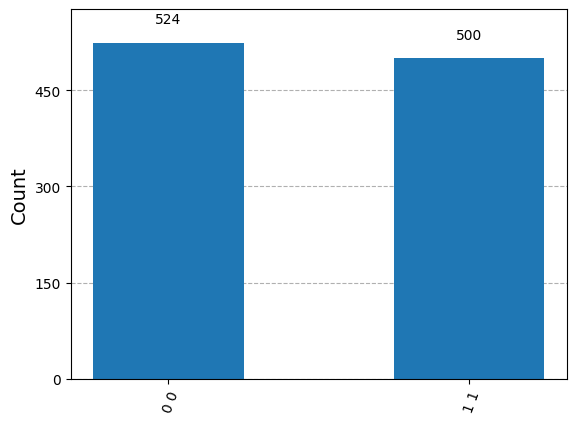

In [9]:
net_counts = {}
N = 1   # Number of noisy circuits generated
p = 0.4
a = 0
for i in range(N):
    qc = BellCircuit_With_EC(p)
    r = transpile(qc, qasm_sim)
    result = qasm_sim.run((r)).result()
    counts = result.get_counts()
    
    for key in counts.keys():
        truncated_key = key[0:3][::-1]
        if truncated_key in net_counts.keys():
            net_counts[truncated_key] += counts[key]
        else:
            net_counts[truncated_key] = counts[key]

if(a == 0):
    a = 1
    plot_histogram(net_counts)